In [1]:
import numpy as np
import scipy as sp
import matplotlib
from matplotlib import pyplot as plt
import pyam
import pandas as pd
import sys
sys.path.append('/Users/stuartjenkins/Documents/$$Work/2019:02:01 - Carbon budgets with CO2-fe paper')
from fair_scm import *

# from scipy.stats import lognorm
# from scipy import stats
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

<IPython.core.display.Javascript object>

In [2]:
# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
co2_ems_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx', encoding='utf-8')
co2_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx', encoding='utf-8')
total_RF_df = pyam.IamDataFrame(data='../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_lower_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx', encoding='utf-8')
two_lower_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx', encoding='utf-8')
two_lower_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx', encoding='utf-8')

# import the datasets from subfolder "15_degree_compatible_scens_IIASA"
two_higher_co2_ems_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx', encoding='utf-8')
two_higher_co2_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx', encoding='utf-8')
two_higher_total_RF_df = pyam.IamDataFrame(data='../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx', encoding='utf-8')

# import RCP85 scenario to stitch onto past
RCP85_E = pd.read_csv('../RCP_data/RCP85_EMISSIONS.csv',skiprows=36,index_col=0)
RCP85_RF = pd.read_csv('../RCP_data/RCP85_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP3_E = pd.read_csv('../RCP_data/RCP3PD_EMISSIONS.csv',skiprows=36,index_col=0)
RCP3_RF = pd.read_csv('../RCP_data/RCP3PD_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP45_E = pd.read_csv('../RCP_data/RCP45_EMISSIONS.csv',skiprows=36,index_col=0)
RCP45_RF = pd.read_csv('../RCP_data/RCP45_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

RCP6_E = pd.read_csv('../RCP_data/RCP6_EMISSIONS.csv',skiprows=36,index_col=0)
RCP6_RF = pd.read_csv('../RCP_data/RCP6_MIDYEAR_RADFORCING.csv',skiprows=58,index_col=0)

INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2ems.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_co2rf.xlsx`
INFO:root:Reading `../15_degree_compatible_scens_IIASA/iamc15_snapshot_totalrf.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2lower.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_ems_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_co2_forcing_2higher.xlsx`
INFO:root:Reading `../2degree_IIASA_scenarios/iamc15_total_forcing_2higher.xlsx`


In [3]:
# what is the year we run the comparison from (chosen because we need 20 years of non-CO2 forcing data find F_0)
year_val = 2018
non_co2_forcing_average_over = 10

fbar_s = np.array([])
f0_s = np.array([])
f1_s = np.array([])
delta_fs = np.array([])

# Parameter values
full_index = np.arange(1765,2101)
TCR_val = 1.6
ECS_val = 2.75
d_array = np.array([239.0,4.1])
F_2x = 3.74
C_0 = 278.0
H = 100 # size of integration for AGWP calculation
epsilon = (ECS_val - TCR_val)/(TCR_val * d_array[0])
gamma = (1 - np.exp(-epsilon*H))/(epsilon*H)

# magicc like AGWP value
r0 = 32.4 # 33.6
rC = 0.019 # 0.0206
rT = 4.165 # 4.635

base_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems = RCP3_E.FossilCO2.values + RCP3_E.OtherCO2.values
pulse_ems[year_val-1765] += 1. * 12 / 44

other_rf = RCP3_RF.TOTAL_ANTHRO_RF.values - RCP3_RF.CO2_RF.values

C_pulse, T_pulse = fair_scm(emissions=pulse_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)
C_base, T_base = fair_scm(emissions=base_ems, other_rf=other_rf, tcrecs=np.array([TCR_val,ECS_val]), d=d_array, C_0=C_0, F_2x=F_2x, r0=r0, rC=rC, rT=rT)

RF_net = (F_2x * np.log(C_pulse / C_0) / np.log(2.0)) - (F_2x * np.log(C_base / C_0) / np.log(2.0))
AGWP_CO2 = sp.integrate.simps(RF_net[year_val-1765:year_val+101-1765])
TCRE = (((H / AGWP_CO2) * (F_2x / TCR_val)) * (12 / 44000))**-1
print('TCR: ',TCR_val,'K\nECS: ',ECS_val,'K\ncalculated TCRE: ', TCRE, 'K/TtC')
print(H/AGWP_CO2)

TCR:  1.6 K
ECS:  2.75 K
calculated TCRE:  1.324006450562502 K/TtC
1184.7581636131479


invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


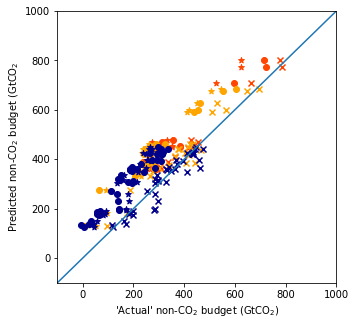

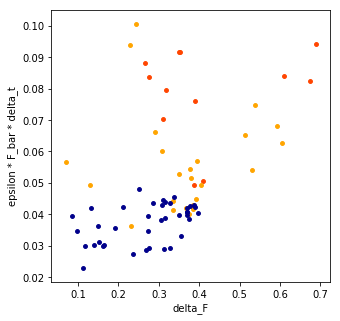

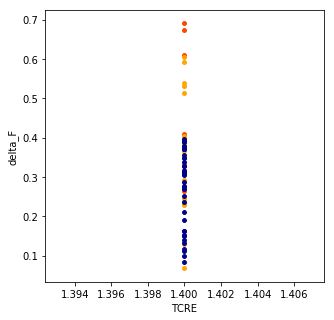

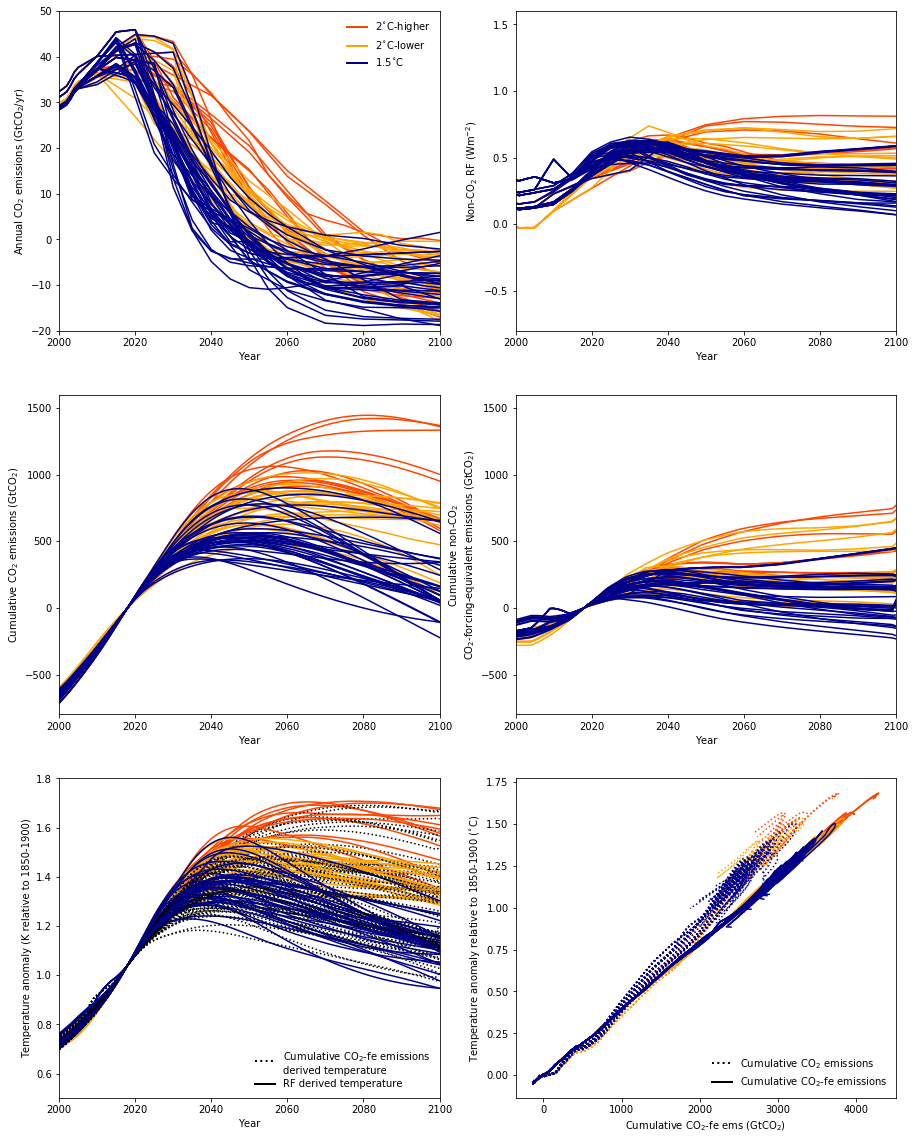

In [6]:
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.plot([-100,1000],[-100,1000])
ax1.set_xlim(-100,1000)
ax1.set_ylim(-100,1000)
ax1.set_xlabel('\'Actual\' non-CO$_2$ budget (GtCO$_2$)')
ax1.set_ylabel('Predicted non-CO$_2$ budget (GtCO$_2$')

fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.set_xlabel('delta_F')
ax2.set_ylabel('epsilon * F_bar * delta_t')

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.set_xlabel('TCRE')
ax3.set_ylabel('delta_F')

fig,ax = plt.subplots(3,2,figsize=(15,20))
ax[0,0].set_xlim(2000,2100)
ax[0,1].set_xlim(2000,2100)
ax[1,0].set_xlim(2000,2100)
ax[1,1].set_xlim(2000,2100)
ax[2,0].set_xlim(2000,2100)
# ax[2,1].set_xlim(0,1600)
# ax[2,1].set_ylim(0,1600)
# ax[2,1].plot([-100,1600],[-100,1600], linestyle=':', color='black', zorder = 0)

ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Cumulative CO$_2$ emissions (GtCO$_2$)')
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Cumulative non-CO$_2$ \nCO$_2$-forcing-equivalent emissions (GtCO$_2$)')
ax[2,0].set_xlabel('Year')
ax[2,0].set_ylabel('Temperature anomaly (K relative to 1850-1900)')
ax[2,1].set_xlabel('Cumulative CO$_2$-fe ems (GtCO$_2$)')
ax[2,1].set_ylabel('Temperature anomaly relative to 1850-1900 ($^{\circ}$C)')

TCRE = 1.4
# AGWP_CO2 = TCRE*(12/44000)*H*F_2x / TCR_val



for n_year_av in [20]:
    
    for i in range(0,len(list(two_higher_co2_ems_df.models()))):
        for j in range(0,len(list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_higher_total_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_higher_co2_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)
            T_total_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
#             TCRE_test = 1000*T_total_back[2005-1765] / np.cumsum(E_total_back)[2005-1765]
#             AGWP_test = TCRE*(12/44000)*H*F_2x / TCR_val
            
            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orangered')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orangered')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orangered')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orangered')
                ax[2,0].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orangered')
                ax[2,0].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='black', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orangered')
                ax[2,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered')
                ax[2,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orangered')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orangered')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orangered', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orangered', s=15)
                
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orangered', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orangered')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

                delta_fs = np.append(delta_fs, F_1 - F_0)
#                 TCRE_effective = 1000 * delta_T / ((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]) + (np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]))
#                 print(TCRE_effective)

            
            
    for i in range(0,len(list(two_lower_co2_ems_df.models()))):
        for j in range(0,len(list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_lower_total_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_lower_co2_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='orange')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='orange')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orange')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orange')
                ax[2,0].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orange')
                ax[2,0].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='black', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orange')   
                ax[2,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange')
                ax[2,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orange')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orange')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orange', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orange', s=15)
                
                T_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orange', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orange')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
  
                delta_fs = np.append(delta_fs, F_1 - F_0)
        
    for i in range(0,len(list(co2_ems_df.models()))):
        for j in range(0,len(list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios()))):
            single_ems = co2_ems_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = total_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = co2_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax[0,0].plot(single_ems.index, single_ems.values*44/12, color='darkblue')
                ax[0,1].plot(single_nonco2rf.index, single_nonco2rf.values, color='darkblue')
                ax[1,0].plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='darkblue')
                ax[1,1].plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='darkblue')
                ax[2,0].plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='darkblue')
                ax[2,0].plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='black', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='darkblue')
                ax[2,1].plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue')
                ax[2,1].plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue',linestyle=':')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='darkblue', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='darkblue', s=15)
                
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='darkblue')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='darkblue')



                T_back, E_total_back = fair_scm_emsback(single_totalrf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                #ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='darkblue', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='darkblue')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                #ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems*44/12, zorder = 10, color='magenta', s=10)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems2*44/12, zorder = 10, color='green', s=10)

                delta_fs = np.append(delta_fs, F_1 - F_0)
        
#                 print((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])[year_temp_max-1765])
#                 print((np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])[year_temp_max-1765])
# print('mean=',np.mean([1.4942851100577366,1.5449778429229493,1.5317666948284399,1.5394267857189985,1.4367083812061985,1.4375890539538407,1.478125614629406,1.4770847648264573,1.5051667954040988,1.5049787451554082,1.5942726336228301,1.5893835194252728]))

ax[2,0].set_ylim(0.5,1.8)
ax[1,1].set_ylim(-800,1600)
ax[1,0].set_ylim(-800,1600)
ax[0,0].set_ylim(-20,50)
ax[0,1].set_ylim(-0.8,1.6)

legend_elements = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$-fe emissions \nderived temperature'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='RF derived temperature')]
ax[2,0].legend(handles=legend_elements, loc='lower right', framealpha=1.0, edgecolor='white')

legend_elements2 = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$ emissions'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='Cumulative CO$_2$-fe emissions')]
ax[2,1].legend(handles=legend_elements2, loc='lower right', framealpha=1.0, edgecolor='white')

legend_elements3 = [Line2D([0], [0], color='orangered', lw=2, linestyle='-', label='2$^{\circ}$C-higher'),
                   Line2D([0], [0], color='orange', lw=2, linestyle='-', label='2$^{\circ}$C-lower'),
                   Line2D([0], [0], color='darkblue', lw=2, linestyle='-', label='1.5$^{\circ}$C')]
ax[0,0].legend(handles=legend_elements3, loc='upper right', framealpha=1.0, edgecolor='white')

ax[0,0].grid(False)

# fig.savefig('Figure1.pdf', dpi=300)

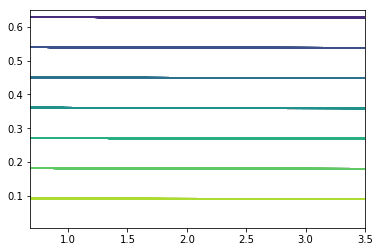

In [5]:
delta_T = 0.5

TCRE_values = np.random.lognormal(0.348, 0.289, 100)

delta_F_values = np.random.uniform(0.0, 0.65, 100)
# delta_F_values = np.random.normal(0.3, 0.15, 100)

X, Y = np.meshgrid(TCRE_values, delta_F_values)

budget_total = delta_T / X

budget_CO2 = budget_total - gamma*H*Y/(AGWP_CO2*44/12)

plt.contour(X,Y,budget_CO2)
plt.show()

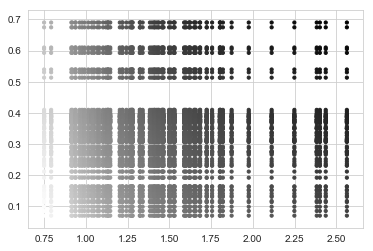

In [7]:
n = delta_fs.size

delta_T = 0.5

TCRE_values = np.random.lognormal(0.348, 0.289, n)

delta_F_values = np.random.uniform(0.0, 0.65, n)

budget_total = (delta_T / TCRE_values)*1000

# budget_non_co2 = gamma*H*delta_F_values/(AGWP_CO2*44/12)
budget_non_co2 = gamma*H*delta_fs/(AGWP_CO2*44/12)

co2_budgets = np.array([])
X = np.array([])
Y = np.array([])

X2, Y2 = np.meshgrid(TCRE_values, delta_fs)

for i in range(0,n):
    co2_budgets = np.append(co2_budgets, budget_total[i] - budget_non_co2)
    X = np.append(X, np.ones(n)*TCRE_values[i])
#     Y = np.append(Y, np.ones(budget_non_co2.size)*delta_F_values[i])
    Y = np.append(Y, delta_fs)
    
plt.scatter(X, Y, c=co2_budgets, s=10, cmap='gray')

# plt.scatter(TCRE_values, delta_F_values, c=, s=10, cmap='gray')
    
# plt.scatter(np.arange(0,100), budget_total, color='blue')
# plt.scatter(np.arange(0,100), budget_non_co2, color='red')

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


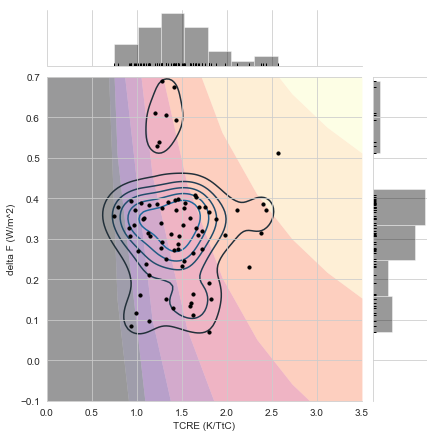

In [8]:
import seaborn as sns
sns.set_style("whitegrid")
# sns.jointplot(TCRE_values,delta_fs,kind="kde", color="m")

g = (sns.jointplot(TCRE_values, delta_fs, color="k", xlim=[0.0,3.5], ylim=[-0.1,0.7], marginal_kws=dict(bins=7, rug=True), s=10)
     .plot_joint(sns.kdeplot, zorder=0, n_levels=6))

g.set_axis_labels('TCRE (K/TtC)','delta F (W/m^2)') 

# g.ax_joint.plot([0.0,0.5], [0.0,-0.1], 'black')
# g.ax_joint.plot([0.0,1.0], [0.1,-0.1], 'gray')
# g.ax_joint.plot([0.0,1.5], [0.2,-0.1], 'grey')
# g.ax_joint.plot([0.0,2.0], [0.3,-0.1], 'green')

# g.ax_joint.fill_between([0.0,1.5], [0.2,-0.1], [0.3,-0.1])

X_vals, Y_vals = np.meshgrid(np.linspace(0.001,3.5,10), np.linspace(-0.1,0.7,10))
Z_vals = (delta_T / X_vals)*1000 - gamma*H*Y_vals/(AGWP_CO2*44/12)

cnt = g.ax_joint.contourf(X_vals, Y_vals, Z_vals, cmap=plt.cm.magma.reversed(), zorder=-100, levels=[0,100,200,300,400,500,600], extend='both', alpha=0.4)

for c in cnt.collections:
    c.set_edgecolor("face")
    c.set_linewidth(0.000000000001)

# g.savefig('figure3_test.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


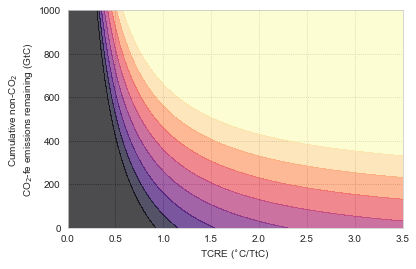

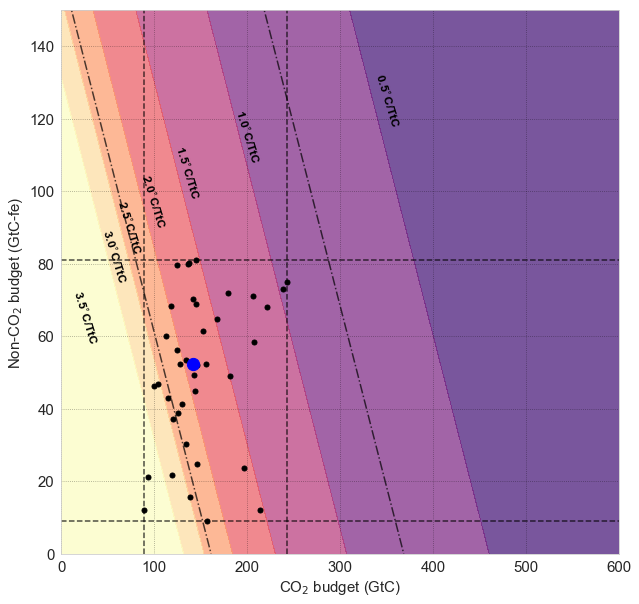

In [150]:
# attempt at new figure 4
n = 100

TCRE_values = np.random.lognormal(0.348, 0.289, n)

total_ems_remaining = (1.5-1.04)*1000/TCRE_values
nonCO2_co2fe_ems = np.arange(0,1000,100)

TCREs, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,3.5,100), np.linspace(0,1000,100))

CO2_budgets = (1.5-1.04)*1000/TCREs - nonCO2_co2fe_budgets

plt.contourf(TCREs, nonCO2_co2fe_budgets, CO2_budgets, [-200,-100,0,100,200,300,400,500], extend='both', cmap=plt.cm.magma.reversed(), alpha=0.7, linewidths=0.0)
plt.grid(True, linestyle=':', color='black', alpha = 0.6)
plt.xlabel('TCRE ($^{\circ}$C/TtC)')
plt.ylabel('Cumulative non-CO$_2$ \nCO$_2$-fe emissions remaining (GtC)')

scen_nonCO2_budgets = [30.172772089960304,37.086188616933086,38.75206042029008,58.48751643383132,49.09180478019327,46.83576290905759,49.46672988296113,46.437475666071904,61.51180104779496,44.78598647597546,52.44669228143334,56.17159093073873,41.42193608215727,52.365409932673074,51.993083992512325,53.47437004150561,43.092123955406706,68.90836925290158,73.17431813677867,80.1952095826671,81.15674362561651,80.09341906460025,79.64223386009903,70.2260156090287,71.85498831137248,68.51204804056516,75.04780673502752,64.85073625519148,68.11756253158178,71.05452273245139,60.004505171945766,24.737658575198537,11.975592234572005,21.269723647565343,15.698403195954072,21.87430906173553,9.004022172042951,12.08803238361969,23.58513780680947]
scen_total_budgets = [164.7431590372331,156.9559691278422,163.72573968756285,265.43054261564976,230.79850205292064,150.25172799996653,192.63527819205217,146.37162330243552,213.4679622538314,188.3463175836115,180.43194523779698,180.47512262492057,171.4840483802842,208.23738695685483,198.3240200348033,187.86774917797823,158.33246853686126,213.96999546572,311.3520963181878,217.10937242798525,225.78066358793455,216.74675184750936,204.20457526314476,212.0901896144835,251.54701126228133,186.79742984601967,317.5543716932093,231.74480693882788,288.9344150261272,276.8864414615424,172.407124462855,170.69130516247117,100.50058519639038,114.63094977483797,154.4524274341362,141.37490411264469,165.40152320295215,225.67428846725625,220.16257915226402]
scen_co2_budgets = np.array(scen_total_budgets) - np.array(scen_nonCO2_budgets)

CO2_budgets, nonCO2_co2fe_budgets = np.meshgrid(np.linspace(0.001,1000,100), np.linspace(0.001,1000,100))
TCREs = (1.5-1.04)*1000/(CO2_budgets + nonCO2_co2fe_budgets)

fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(scen_co2_budgets, scen_nonCO2_budgets, color='black', s=25)
plt.scatter(np.median(scen_co2_budgets), np.median(scen_nonCO2_budgets), color='blue', s=150)
plt.contourf(CO2_budgets, nonCO2_co2fe_budgets, TCREs, [0,0.5,1.0,1.5,2.0,2.5,3.0,3.5], cmap=plt.cm.magma, alpha=0.7, linewidths=0.0, zorder=-100, extend='both')
plt.xlim(0,600)
plt.ylim(0,150)
plt.grid(True, color='black', linestyle=':', alpha=0.4)
# plt.text(335,130,'0.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(185,120,'1.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(120,110,'1.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(83,100,'2.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(60,90,'2.5$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(45,80,'3.0$^{\circ}$C/TtC', color='black', fontsize=12)
# plt.text(10,70,'3.5$^{\circ}$C/TtC', color='black', fontsize=12)
plt.annotate('0.5$^{\circ}$C/TtC',xy=(335,130),rotation=-73,color='black',fontsize=12, fontweight='bold')
plt.annotate('1.0$^{\circ}$C/TtC',xy=(185,120),rotation=-73,color='black',fontsize=12, fontweight='bold')
plt.annotate('1.5$^{\circ}$C/TtC',xy=(120,110),rotation=-73,color='black',fontsize=12, fontweight='bold')
plt.annotate('2.0$^{\circ}$C/TtC',xy=(83,102),rotation=-73,color='black',fontsize=12, fontweight='bold')
plt.annotate('2.5$^{\circ}$C/TtC',xy=(58,95),rotation=-73,color='black',fontsize=12, fontweight='bold')
plt.annotate('3.0$^{\circ}$C/TtC',xy=(42,87),rotation=-73,color='black',fontsize=12, fontweight='bold')
plt.annotate('3.5$^{\circ}$C/TtC',xy=(10,70),rotation=-73,color='black',fontsize=12, fontweight='bold')

ax.plot([np.min(scen_co2_budgets), np.min(scen_co2_budgets)],[0,1000], linestyle='--', color='black', alpha=0.7)
ax.plot([np.max(scen_co2_budgets), np.max(scen_co2_budgets)],[0,1000], linestyle='--', color='black', alpha=0.7)
ax.plot([0,1000],[np.min(scen_nonCO2_budgets), np.min(scen_nonCO2_budgets)], linestyle='--', color='black', alpha=0.7)
ax.plot([0,1000],[np.max(scen_nonCO2_budgets), np.max(scen_nonCO2_budgets)], linestyle='--', color='black', alpha=0.7)

ax.plot([0,155 + ((185-155)/5)],[155 + ((185-155)*1/5),0], linestyle='-.', color='black', alpha=0.7)

ax.plot([0,307 + ((460-307)*2/5)],[307 + ((460-307)*2/5),0], linestyle='-.', color='black', alpha=0.7)

ax.set_xticklabels([0,100,200,300,400,500,600], fontsize=15)
ax.set_yticklabels([0,20,40,60,80,100,120,140], fontsize=15)
ax.set_xlabel('CO$_2$ budget (GtC)', fontsize=15)
ax.set_ylabel('Non-CO$_2$ budget (GtC-fe)', fontsize=15)
plt.show()

# fig.savefig('Figure4.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D


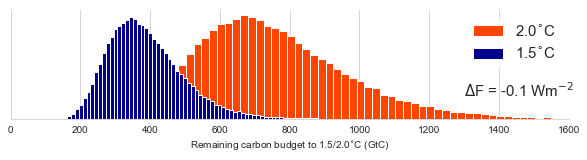

In [73]:
fig2, ax2 = plt.subplots(figsize=(10,2))

F_present = 0.4
F_2030 = 0.5
F_2050 = 0.3

F_total = np.zeros(2100-1998+1)
gradient_pres_to_2030 = (F_2030 - F_present) / (2030 - 2018)
F_total[:2031-1998] = np.arange(-20,13) * gradient_pres_to_2030 + F_present

gradient_2030_to_2050 = (F_2050 - F_2030) / 20
F_total[2030-1998:2051-1998] = np.arange(0,21) * gradient_2030_to_2050 + F_2030

F_total[2050-1998:] = F_total[2050-1998]

F_bar = np.mean(F_total[2018-1998:2101-1998])
delta_F = F_2050 - F_present



delta_T = 1.0

TCRE_values = np.random.lognormal(0.348, 0.289, n)

delta_F_values = [delta_F]
delta_t_s = [2050-2018]
F_bar_value = F_bar

budget_total = (delta_T / TCRE_values)*1000

co2_budgets = np.zeros((n,3))

cols = ['darkblue','orange','orangered', 'darkred']

for k, delta_F_value in enumerate(delta_F_values):

    for j,delta_t in enumerate(delta_t_s):
        budget_non_co2 = gamma*H*(delta_F_value + epsilon*delta_t*F_bar_value)/(AGWP_CO2*44/12)

        for i in range(0,n):
            co2_budgets[i,j] = budget_total[i] - budget_non_co2

        ax2.hist(co2_budgets[:,j], bins = 100, color=cols[2], alpha = 1.0)



legend_elements = [Patch(facecolor='orangered', edgecolor='white', label='2.0$^{\circ}$C', alpha=1.0),
                   Patch(facecolor='darkblue', edgecolor='white', label='1.5$^{\circ}$C', alpha=1.0)]

ax2.legend(handles=legend_elements, loc='upper right', edgecolor='white', fontsize=15)



delta_T = 0.5

TCRE_values = np.random.lognormal(0.348, 0.289, n)

delta_F_values = [delta_F]
delta_t_s = [2050-2018]
F_bar_value = F_bar

budget_total = (delta_T / TCRE_values)*1000

co2_budgets_0pt5 = np.zeros((n,3))

ax2.set_xlabel('Remaining carbon budget to 1.5/2.0$^{\circ}$C (GtC)')
# ax2.set_xlim(0,800)
cols = ['darkblue','orange','orangered', 'darkred']

for k, delta_F_value in enumerate(delta_F_values):
    ax2.text(1300,1000,'$\Delta$F = ' + str(np.round(delta_F_value,3)) + ' Wm$^{-2}$', fontsize=15)
    
    for j,delta_t in enumerate(delta_t_s):
        budget_non_co2 = gamma*H*(delta_F_value + epsilon*delta_t*F_bar_value)/(AGWP_CO2*44/12)

        for i in range(0,n):
            co2_budgets_0pt5[i,j] = budget_total[i] - budget_non_co2

#         ax[k].hist(co2_budgets[:,j], bins = 100, color=cols[k], alpha=0.1)
#         h2 = ax2[k].hist(np.log(co2_budgets[:,j][co2_budgets[:,j]>0]), bins = 100, color=cols[k], alpha=0.1)
    ax2.hist(co2_budgets_0pt5[:,j], bins = 100, color=cols[0], alpha = 1.0)
    ax2.set_xlim(0,1600)
    ax2.spines['top'].set_visible(False)
    ax2.yaxis.set_ticks([])
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)

output_1 = sp.stats.gaussian_kde(co2_budgets[:,0], bw_method='silverman')
output_0pt5 = sp.stats.gaussian_kde(co2_budgets_0pt5[:,0], bw_method='silverman')

plt.show()

# fig2.savefig('fig3_test.pdf', dpi=300)

In [74]:
y_1 = output_1(np.arange(0,1600))
y_0pt5 = output_0pt5(np.arange(0,1600))

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D


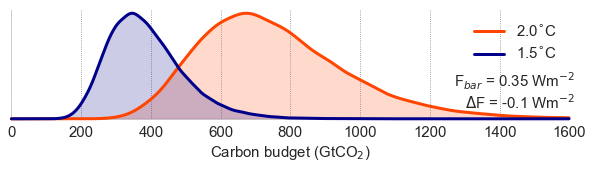

In [85]:
fig,ax = plt.subplots(figsize=(10,2))

ax.fill_between(np.arange(0,1600), y_1/np.max(y_1), np.zeros(y_1.size), color='orangered', alpha=0.2)
ax.fill_between(np.arange(0,1600), y_0pt5/np.max(y_0pt5), np.zeros(y_0pt5.size), color='darkblue', alpha=0.2)
ax.plot(np.arange(0,1600), y_1/np.max(y_1), color='orangered', linewidth=3, clip_on=False, zorder=100)
ax.plot(np.arange(0,1600), y_0pt5/np.max(y_0pt5), color='darkblue', linewidth=3, clip_on=False, zorder=101)

legend_elements = [Line2D([0], [0], color='orangered', lw=3, label='2.0$^{\circ}$C'),
                  Line2D([0], [0], color='darkblue', lw=3, label='1.5$^{\circ}$C')]

ax.legend(handles=legend_elements, loc='upper right', edgecolor='white', fontsize=15, framealpha=0.0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0,1600)
ax.set_ylim(0,1.03)
ax.grid(True, linestyle=':', color='black', alpha=0.5)
ax.text(1300,0.1,'$\Delta$F = ' + str(np.round(delta_F_value,3)) + ' Wm$^{-2}$', fontsize=15)
ax.text(1268,0.3,'F$_{bar}$ = ' + str(np.round(F_bar_value,2)) + ' Wm$^{-2}$', fontsize=15)
# ax.xaxis.set_fontsize(15)
ax.set_yticks([])
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Carbon budget (GtCO$_2$)', fontsize=15)
plt.show()

# fig.savefig('figure3.pdf', dpi=300)

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c


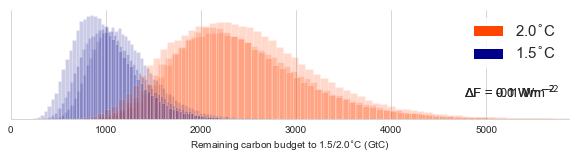

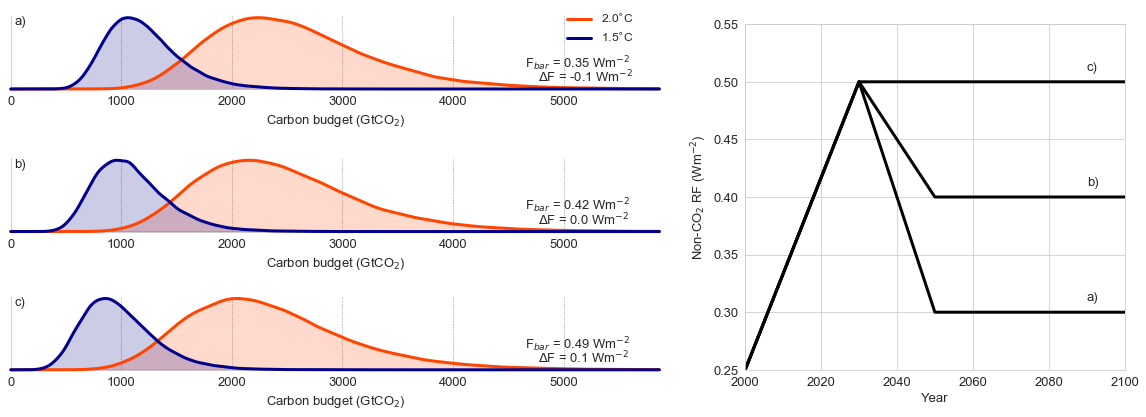

In [119]:
fig2, ax2 = plt.subplots(figsize=(10,2))
# fig3, ax3 = plt.subplots(3,1,figsize=(10,6))
fig3 = plt.figure(figsize=(17,6))

left = 0.05
width = 0.53

ax31 = fig3.add_axes([left, 0.75, width, 0.17])
ax32 = fig3.add_axes([left, 0.42, width, 0.17])
ax33 = fig3.add_axes([left, 0.1, width, 0.17])
ax34 = fig3.add_axes([left+width+left+0.02, 0.1, 0.31, 0.8])
ax3 = [ax31, ax32, ax33, ax34]
strings_to_plot = ['a)','b)','c)']

for l,F_2050 in enumerate([0.3,0.4,0.5]):

    F_present = 0.4
    F_2030 = 0.5
#     F_2050 = 0.3

    F_total = np.zeros(2100-1998+1)
    gradient_pres_to_2030 = (F_2030 - F_present) / (2030 - 2018)
    F_total[:2031-1998] = np.arange(-20,13) * gradient_pres_to_2030 + F_present

    gradient_2030_to_2050 = (F_2050 - F_2030) / 20
    F_total[2030-1998:2051-1998] = np.arange(0,21) * gradient_2030_to_2050 + F_2030

    F_total[2050-1998:] = F_total[2050-1998]

    F_bar = np.mean(F_total[2018-1998:2101-1998])
    delta_F = F_2050 - F_present

    ax3[3].plot(np.arange(1998,2101), F_total, color='black', linewidth=3)
    ax3[3].text(2090, F_2050+0.01, strings_to_plot[l], fontsize=13)

    delta_T = 0.92

    TCRE_values = np.random.lognormal(0.348, 0.289, n)

    delta_F_values = [delta_F]
    delta_t_s = [2050-2018]
    F_bar_value = F_bar

    budget_total = (delta_T / TCRE_values)*1000*44/12

    co2_budgets = np.zeros((n,3))

    cols = ['darkblue','orange','orangered', 'darkred']

    for k, delta_F_value in enumerate(delta_F_values):

        for j,delta_t in enumerate(delta_t_s):
            budget_non_co2 = gamma*H*(delta_F_value + epsilon*delta_t*F_bar_value)/(AGWP_CO2)

            for i in range(0,n):
                co2_budgets[i,j] = budget_total[i] - budget_non_co2

            ax2.hist(co2_budgets[:,j], bins = 100, color=cols[2], alpha = 0.2)



    legend_elements = [Patch(facecolor='orangered', edgecolor='white', label='2.0$^{\circ}$C', alpha=1.0),
                       Patch(facecolor='darkblue', edgecolor='white', label='1.5$^{\circ}$C', alpha=1.0)]

    ax2.legend(handles=legend_elements, loc='upper right', edgecolor='white', fontsize=15)



    delta_T = 0.42

    TCRE_values = np.random.lognormal(0.348, 0.289, n)

    delta_F_values = [delta_F]
    delta_t_s = [2050-2018]
    F_bar_value = F_bar

    budget_total = (delta_T / TCRE_values)*1000*44/12

    co2_budgets_0pt5 = np.zeros((n,3))

    ax2.set_xlabel('Remaining carbon budget to 1.5/2.0$^{\circ}$C (GtC)')
    # ax2.set_xlim(0,800)
    cols = ['darkblue','orange','orangered', 'darkred']

    for k, delta_F_value in enumerate(delta_F_values):
        ax2.text(1300*44/12,1000,'$\Delta$F = ' + str(np.round(delta_F_value,3)) + ' Wm$^{-2}$', fontsize=13)

        for j,delta_t in enumerate(delta_t_s):
            budget_non_co2 = gamma*H*(delta_F_value + epsilon*delta_t*F_bar_value)/(AGWP_CO2)

            for i in range(0,n):
                co2_budgets_0pt5[i,j] = budget_total[i] - budget_non_co2

    #         ax[k].hist(co2_budgets[:,j], bins = 100, color=cols[k], alpha=0.1)
    #         h2 = ax2[k].hist(np.log(co2_budgets[:,j][co2_budgets[:,j]>0]), bins = 100, color=cols[k], alpha=0.1)
        ax2.hist(co2_budgets_0pt5[:,j], bins = 100, color=cols[0], alpha = 0.2)
        ax2.set_xlim(0,1600*44/12)
        ax2.spines['top'].set_visible(False)
        ax2.yaxis.set_ticks([])
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)

    output_1 = sp.stats.gaussian_kde(co2_budgets[:,0], bw_method='silverman')
    output_0pt5 = sp.stats.gaussian_kde(co2_budgets_0pt5[:,0], bw_method='silverman')
    
    
    y_1 = output_1(np.arange(0,1600*44/12))
    y_0pt5 = output_0pt5(np.arange(0,1600*44/12))

    ax3[l].fill_between(np.arange(0,1600*44/12), y_1/np.max(y_1), np.zeros(y_1.size), color='orangered', alpha=0.2)
    ax3[l].fill_between(np.arange(0,1600*44/12), y_0pt5/np.max(y_0pt5), np.zeros(y_0pt5.size), color='darkblue', alpha=0.2)
    ax3[l].plot(np.arange(0,1600*44/12), y_1/np.max(y_1), color='orangered', linewidth=3, clip_on=False, zorder=100)
    ax3[l].plot(np.arange(0,1600*44/12), y_0pt5/np.max(y_0pt5), color='darkblue', linewidth=3, clip_on=False, zorder=101)

    ax3[l].spines['top'].set_visible(False)
    ax3[l].spines['right'].set_visible(False)
    ax3[l].set_xlim(0,1600*44/12)
    ax3[l].set_ylim(0,1.03)
    ax3[l].grid(True, linestyle=':', color='black', alpha=0.5)
    ax3[l].text(1300*44/12,0.1,'$\Delta$F = ' + str(np.round(delta_F_value,3)) + ' Wm$^{-2}$', fontsize=13)
    ax3[l].text(1268*44/12,0.3,'F$_{bar}$ = ' + str(np.round(F_bar_value,2)) + ' Wm$^{-2}$', fontsize=13)
    # ax.xaxis.set_fontsize(15)
    ax3[l].set_yticks([])
    ax3[l].tick_params(axis='both', which='major', labelsize=13)
    ax3[l].set_xlabel('Carbon budget (GtCO$_2$)', fontsize=13)
    if l < 3:
        ax3[l].text(30,0.9,strings_to_plot[l], fontsize=13)
    
legend_elements = [Line2D([0], [0], color='orangered', lw=3, label='2.0$^{\circ}$C'),
                      Line2D([0], [0], color='darkblue', lw=3, label='1.5$^{\circ}$C')]

ax3[0].legend(handles=legend_elements, loc=[0.85,0.55], edgecolor='white', fontsize=12, framealpha=0.0)
ax3[3].set_ylim(0.25,0.55)
ax3[3].set_xlim(2000,2100)
ax3[3].set_xlabel('Year', fontsize=13)
ax3[3].set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)', fontsize=13)
ax3[3].tick_params(axis='both', which='major', labelsize=13)
plt.show()

# fig3.savefig('fig3_3forcingDeltas.pdf', dpi=300)

In [208]:
RWF_vals = np.random.normal(0.6,0.0915,1000)
TCR_vals = np.random.lognormal(0.458, 0.279, 1000)
ECS_vals = TCR_vals/RWF_vals

0
10
20
30


divide by zero encountered in true_divide


40
50
60
70
80
90


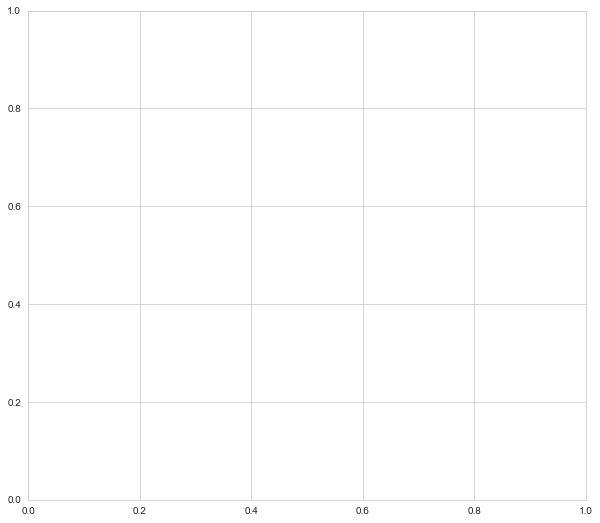

In [257]:
# check on size of budget
fig1, ax1 = plt.subplots(figsize=(10,9))
co2_budgets = np.zeros(1000)

F_present = 0.4
F_2030 = 0.5
F_2050 = 0.3
F_total = np.zeros(2100-1998+1)
gradient_pres_to_2030 = (F_2030 - F_present) / (2030 - 2018)
F_total[:2031-1998] = np.arange(-20,13) * gradient_pres_to_2030 + F_present
gradient_2030_to_2050 = (F_2050 - F_2030) / 20
F_total[2030-1998:2051-1998] = np.arange(0,21) * gradient_2030_to_2050 + F_2030
F_total[2050-1998:] = F_total[2050-1998]


def func_to_minimize(zero_year):
    
    co2_ems = np.zeros(2501-1765)
    co2_ems[:2021-1765] = RCP85_E.FossilCO2.loc[:2020].values + RCP85_E.OtherCO2.loc[:2020].values
    nonco2_rf = np.zeros(2501-1765)
    nonco2_rf[:2021-1765] = RCP85_RF.TOTAL_ANTHRO_RF.loc[:2020].values - RCP85_RF.CO2_RF.loc[:2020].values
    co2_ems[2020-1765:int(zero_year)-1765] = co2_ems[2020-1765]/(2020-zero_year)*np.arange(0,int(zero_year-2020)) + co2_ems[2020-1765]
#     co2_ems[2020-1765:int(zero_year)-1765] = np.linspace(co2_ems[2020-1765], 0.0, int(zero_year)-2020)
    nonco2_rf[2020-1765:2101-1765] = F_total[2020-1998:]
    nonco2_rf[2101-1765:] = F_total[-1]
    
    T = fair_scm(emissions=co2_ems, other_rf=nonco2_rf, tcrecs=np.array([TCR_val, ECS_val]))[1]
    
    return (np.max(T[2018-1765:2101-1765]) - T[2018-1765] - 0.42)**2


for i in range(0,100):

    TCR_val = TCR_vals[i]
    ECS_val = ECS_vals[i]

    if i%10 == 0:
        print(i)
    
    x = sp.optimize.minimize(func_to_minimize, 2030, method = 'L-BFGS-B', bounds=((2020,None),))

#     print(x)
    
    co2_ems = np.zeros(2501-1765)
    co2_ems[:2021-1765] = RCP85_E.FossilCO2.loc[:2020].values + RCP85_E.OtherCO2.loc[:2020].values
    co2_ems[2020-1765:int(x.x)-1765] = co2_ems[2020-1765]/(2020-x.x)*np.arange(0,int(x.x-2020)) + co2_ems[2020-1765]

    co2_budgets[i] = np.sum(co2_ems[2018-1765:int(x.x)-1764])


100


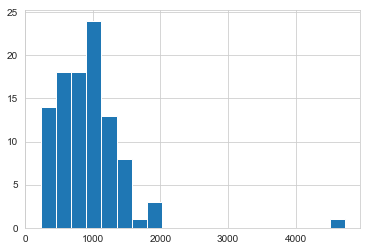

In [258]:
print(co2_budgets[co2_budgets>0].size)
# print(TCR_vals[24], ECS_vals[24])

# print(func_to_minimize(2050))
# print(func_to_minimize(2060))
# print(func_to_minimize(2070))
# print(func_to_minimize(2080))
# print(func_to_minimize(2090))
# print(func_to_minimize(2100))

h4 = plt.hist(co2_budgets[co2_budgets!=0]*44/12, bins = 20)
plt.show()

co2_budget_check = co2_budgets[co2_budgets!=0].copy()

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \D
invalid escape sequence \D
invalid escape sequence \c
invalid escape sequence \c


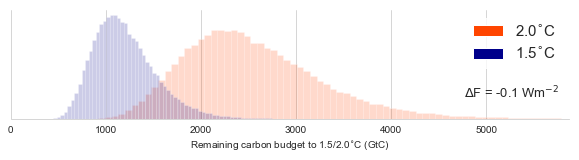

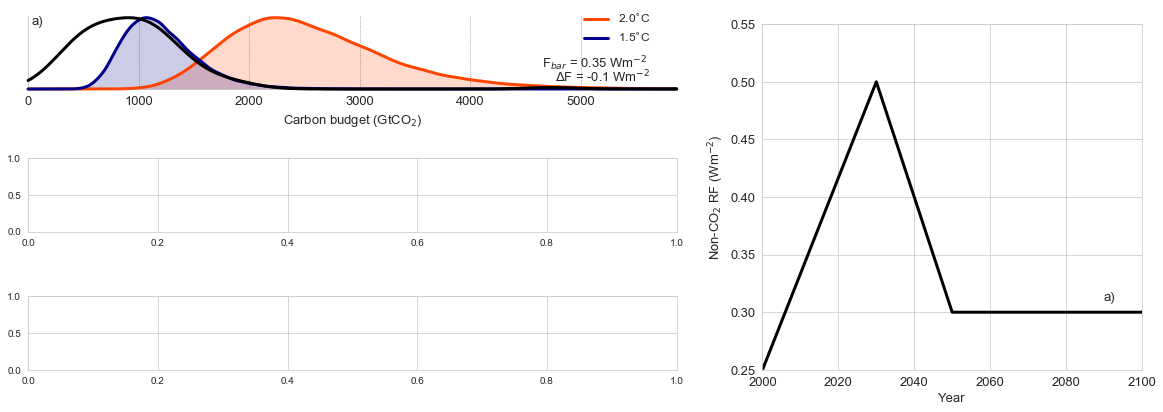

In [259]:
fig2, ax2 = plt.subplots(figsize=(10,2))
# fig3, ax3 = plt.subplots(3,1,figsize=(10,6))
fig3 = plt.figure(figsize=(17,6))

left = 0.05
width = 0.53

ax31 = fig3.add_axes([left, 0.75, width, 0.17])
ax32 = fig3.add_axes([left, 0.42, width, 0.17])
ax33 = fig3.add_axes([left, 0.1, width, 0.17])
ax34 = fig3.add_axes([left+width+left+0.02, 0.1, 0.31, 0.8])
ax3 = [ax31, ax32, ax33, ax34]
strings_to_plot = ['a)','b)','c)']

for l,F_2050 in enumerate([0.3]):

    F_present = 0.4
    F_2030 = 0.5
#     F_2050 = 0.3

    F_total = np.zeros(2100-1998+1)
    gradient_pres_to_2030 = (F_2030 - F_present) / (2030 - 2018)
    F_total[:2031-1998] = np.arange(-20,13) * gradient_pres_to_2030 + F_present

    gradient_2030_to_2050 = (F_2050 - F_2030) / 20
    F_total[2030-1998:2051-1998] = np.arange(0,21) * gradient_2030_to_2050 + F_2030

    F_total[2050-1998:] = F_total[2050-1998]

    F_bar = np.mean(F_total[2018-1998:2101-1998])
    delta_F = F_2050 - F_present

    ax3[3].plot(np.arange(1998,2101), F_total, color='black', linewidth=3)
    ax3[3].text(2090, F_2050+0.01, strings_to_plot[l], fontsize=13)

    delta_T = 0.92

    TCRE_values = np.random.lognormal(0.348, 0.289, n)

    delta_F_values = [delta_F]
    delta_t_s = [2050-2018]
    F_bar_value = F_bar

    budget_total = (delta_T / TCRE_values)*1000*44/12

    co2_budgets = np.zeros((n,3))

    cols = ['darkblue','orange','orangered', 'darkred']

    for k, delta_F_value in enumerate(delta_F_values):

        for j,delta_t in enumerate(delta_t_s):
            budget_non_co2 = gamma*H*(delta_F_value + epsilon*delta_t*F_bar_value)/(AGWP_CO2)

            for i in range(0,n):
                co2_budgets[i,j] = budget_total[i] - budget_non_co2

            ax2.hist(co2_budgets[:,j], bins = 100, color=cols[2], alpha = 0.2)



    legend_elements = [Patch(facecolor='orangered', edgecolor='white', label='2.0$^{\circ}$C', alpha=1.0),
                       Patch(facecolor='darkblue', edgecolor='white', label='1.5$^{\circ}$C', alpha=1.0)]

    ax2.legend(handles=legend_elements, loc='upper right', edgecolor='white', fontsize=15)



    delta_T = 0.42

    TCRE_values = np.random.lognormal(0.348, 0.289, n)

    delta_F_values = [delta_F]
    delta_t_s = [2050-2018]
    F_bar_value = F_bar

    budget_total = (delta_T / TCRE_values)*1000*44/12

    co2_budgets_0pt5 = np.zeros((n,3))

    ax2.set_xlabel('Remaining carbon budget to 1.5/2.0$^{\circ}$C (GtC)')
    # ax2.set_xlim(0,800)
    cols = ['darkblue','orange','orangered', 'darkred']

    for k, delta_F_value in enumerate(delta_F_values):
        ax2.text(1300*44/12,1000,'$\Delta$F = ' + str(np.round(delta_F_value,3)) + ' Wm$^{-2}$', fontsize=13)

        for j,delta_t in enumerate(delta_t_s):
            budget_non_co2 = gamma*H*(delta_F_value + epsilon*delta_t*F_bar_value)/(AGWP_CO2)

            for i in range(0,n):
                co2_budgets_0pt5[i,j] = budget_total[i] - budget_non_co2

    #         ax[k].hist(co2_budgets[:,j], bins = 100, color=cols[k], alpha=0.1)
    #         h2 = ax2[k].hist(np.log(co2_budgets[:,j][co2_budgets[:,j]>0]), bins = 100, color=cols[k], alpha=0.1)
        ax2.hist(co2_budgets_0pt5[:,j], bins = 100, color=cols[0], alpha = 0.2)
        ax2.set_xlim(0,1600*44/12)
        ax2.spines['top'].set_visible(False)
        ax2.yaxis.set_ticks([])
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)

    output_1 = sp.stats.gaussian_kde(co2_budgets[:,0], bw_method='silverman')
    output_0pt5 = sp.stats.gaussian_kde(co2_budgets_0pt5[:,0], bw_method='silverman')
    
    
    y_1 = output_1(np.arange(0,1600*44/12))
    y_0pt5 = output_0pt5(np.arange(0,1600*44/12))

    ax3[l].fill_between(np.arange(0,1600*44/12), y_1/np.max(y_1), np.zeros(y_1.size), color='orangered', alpha=0.2)
    ax3[l].fill_between(np.arange(0,1600*44/12), y_0pt5/np.max(y_0pt5), np.zeros(y_0pt5.size), color='darkblue', alpha=0.2)
    ax3[l].plot(np.arange(0,1600*44/12), y_1/np.max(y_1), color='orangered', linewidth=3, clip_on=False, zorder=100)
    ax3[l].plot(np.arange(0,1600*44/12), y_0pt5/np.max(y_0pt5), color='darkblue', linewidth=3, clip_on=False, zorder=101)

    ax3[l].spines['top'].set_visible(False)
    ax3[l].spines['right'].set_visible(False)
    ax3[l].set_xlim(0,1600*44/12)
    ax3[l].set_ylim(0,1.03)
    ax3[l].grid(True, linestyle=':', color='black', alpha=0.5)
    ax3[l].text(1300*44/12,0.1,'$\Delta$F = ' + str(np.round(delta_F_value,3)) + ' Wm$^{-2}$', fontsize=13)
    ax3[l].text(1268*44/12,0.3,'F$_{bar}$ = ' + str(np.round(F_bar_value,2)) + ' Wm$^{-2}$', fontsize=13)
    # ax.xaxis.set_fontsize(15)
    ax3[l].set_yticks([])
    ax3[l].tick_params(axis='both', which='major', labelsize=13)
    ax3[l].set_xlabel('Carbon budget (GtCO$_2$)', fontsize=13)
    if l < 3:
        ax3[l].text(30,0.9,strings_to_plot[l], fontsize=13)
    
legend_elements = [Line2D([0], [0], color='orangered', lw=3, label='2.0$^{\circ}$C'),
                      Line2D([0], [0], color='darkblue', lw=3, label='1.5$^{\circ}$C')]

ax3[0].legend(handles=legend_elements, loc=[0.85,0.55], edgecolor='white', fontsize=12, framealpha=0.0)
ax3[3].set_ylim(0.25,0.55)
ax3[3].set_xlim(2000,2100)
ax3[3].set_xlabel('Year', fontsize=13)
ax3[3].set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)', fontsize=13)
ax3[3].tick_params(axis='both', which='major', labelsize=13)

output_0pt5_check = sp.stats.gaussian_kde(co2_budget_check*44/12, bw_method='silverman')
y_0pt5_check = output_0pt5_check(np.arange(0,1600*44/12))
ax3[0].plot(np.arange(0,1600*44/12), y_0pt5_check/np.max(y_0pt5_check), color='black', linewidth=3, clip_on=False, zorder=101)
plt.show()

divide by zero encountered in double_scalars


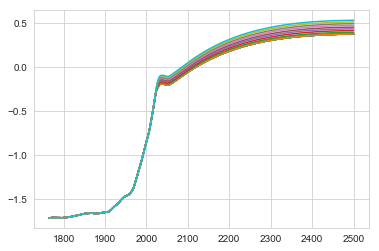

In [249]:
# print(func_to_minimize(2000))
# print(func_to_minimize(2010))
# print(func_to_minimize(2020))
# print(func_to_minimize(2030))
# print(func_to_minimize(2040))
# print(func_to_minimize(2050))

for i in np.arange(2000,2030):
    plt.plot(np.arange(1765,2501), func_to_minimize(i)[1] - func_to_minimize(i)[1][2018-1765] - 0.42)
    
plt.show()

invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c
invalid escape sequence \c


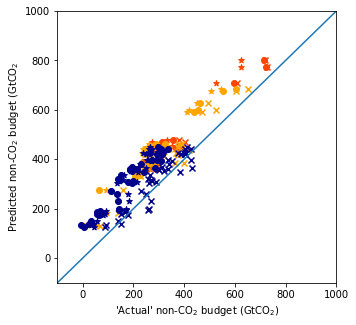

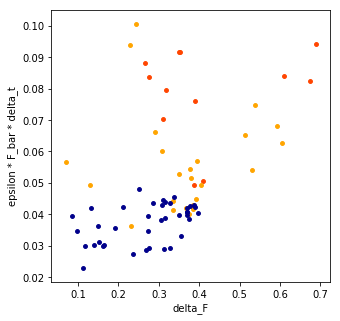

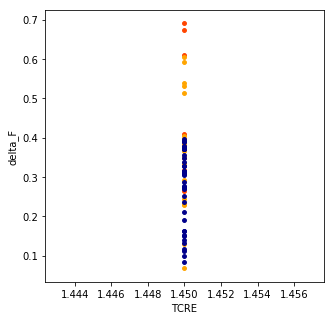

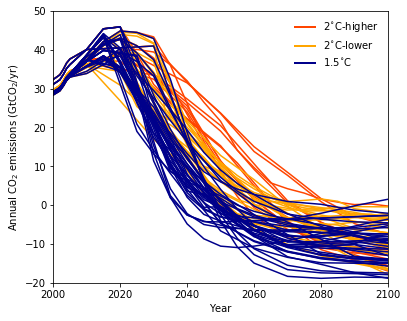

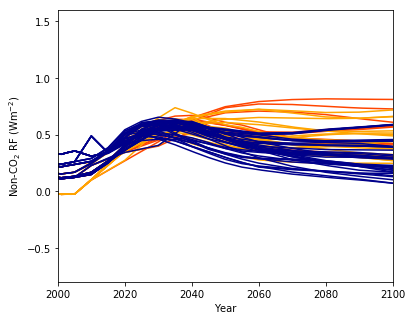

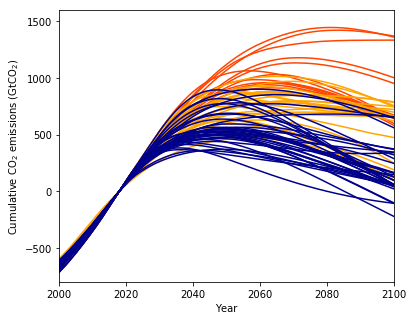

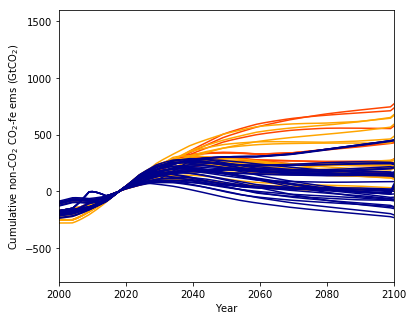

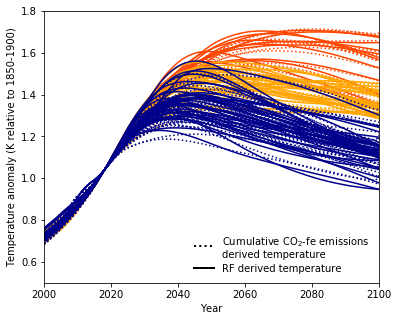

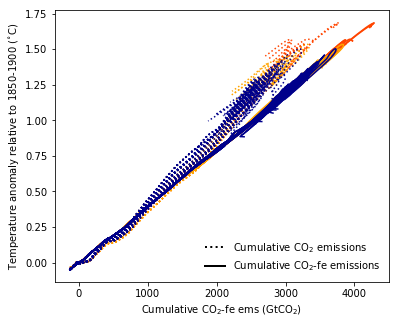

In [5]:
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.plot([-100,1000],[-100,1000])
ax1.set_xlim(-100,1000)
ax1.set_ylim(-100,1000)
ax1.set_xlabel('\'Actual\' non-CO$_2$ budget (GtCO$_2$)')
ax1.set_ylabel('Predicted non-CO$_2$ budget (GtCO$_2$')

fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.set_xlabel('delta_F')
ax2.set_ylabel('epsilon * F_bar * delta_t')

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.set_xlabel('TCRE')
ax3.set_ylabel('delta_F')

fig11,ax11 = plt.subplots(figsize=(6,5))
fig12,ax12 = plt.subplots(figsize=(6,5))
fig13,ax13 = plt.subplots(figsize=(6,5))
fig14,ax14 = plt.subplots(figsize=(6,5))
fig15,ax15 = plt.subplots(figsize=(6,5))
fig16,ax16 = plt.subplots(figsize=(6,5))
ax11.set_xlim(2000,2100)
ax12.set_xlim(2000,2100)
ax13.set_xlim(2000,2100)
ax14.set_xlim(2000,2100)
ax15.set_xlim(2000,2100)
# ax[2,1].set_xlim(0,1600)
# ax[2,1].set_ylim(0,1600)
# ax[2,1].plot([-100,1600],[-100,1600], linestyle=':', color='black', zorder = 0)

ax11.set_xlabel('Year')
ax11.set_ylabel('Annual CO$_2$ emissions (GtCO$_2$/yr)')
ax12.set_xlabel('Year')
ax12.set_ylabel('Non-CO$_2$ RF (Wm$^{-2}$)')
ax13.set_xlabel('Year')
ax13.set_ylabel('Cumulative CO$_2$ emissions (GtCO$_2$)')
ax14.set_xlabel('Year')
ax14.set_ylabel('Cumulative non-CO$_2$ CO$_2$-fe ems (GtCO$_2$)')
ax15.set_xlabel('Year')
ax15.set_ylabel('Temperature anomaly (K relative to 1850-1900)')
ax16.set_xlabel('Cumulative CO$_2$-fe ems (GtCO$_2$)')
ax16.set_ylabel('Temperature anomaly relative to 1850-1900 ($^{\circ}$C)')

TCRE = 1.45
# AGWP_CO2 = TCRE*(12/44000)*H*F_2x / TCR_val



for n_year_av in [20]:
    
    for i in range(0,len(list(two_higher_co2_ems_df.models()))):
        for j in range(0,len(list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_higher_total_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_higher_co2_RF_df.filter(model=list(two_higher_co2_ems_df.models())[i], scenario=list(two_higher_co2_ems_df.filter(model=list(two_higher_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)
            T_total_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
#             TCRE_test = 1000*T_total_back[2005-1765] / np.cumsum(E_total_back)[2005-1765]
#             AGWP_test = TCRE*(12/44000)*H*F_2x / TCR_val
            
            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax11.plot(single_ems.index, single_ems.values*44/12, color='orangered')
                ax12.plot(single_nonco2rf.index, single_nonco2rf.values, color='orangered')
                ax13.plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orangered')
                ax14.plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orangered')
                ax15.plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orangered')
                ax15.plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='orangered', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orangered')
                ax16.plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered')
                ax16.plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orangered',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orangered')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orangered')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orangered', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orangered', s=15)
                
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orangered', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orangered')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

                delta_fs = np.append(delta_fs, F_1 - F_0)
#                 TCRE_effective = 1000 * delta_T / ((np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]) + (np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]))
#                 print(TCRE_effective)

            
            
    for i in range(0,len(list(two_lower_co2_ems_df.models()))):
        for j in range(0,len(list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios()))):
            single_ems = two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = two_lower_total_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = two_lower_co2_RF_df.filter(model=list(two_lower_co2_ems_df.models())[i], scenario=list(two_lower_co2_ems_df.filter(model=list(two_lower_co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax11.plot(single_ems.index, single_ems.values*44/12, color='orange')
                ax12.plot(single_nonco2rf.index, single_nonco2rf.values, color='orange')
                ax13.plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='orange')
                ax14.plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='orange')
                ax15.plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='orange')
                ax15.plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='orange', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='orange')   
                ax16.plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange')
                ax16.plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='orange',linestyle=':')
    
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='orange')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='orange')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='orange', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='orange', s=15)
                
                T_back, E_total_back = fair_scm_emsback(F_2x*np.log(C_run/C_0)/np.log(2.0) + single_nonco2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
#                 ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='orange', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='orange')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

#                 ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)
  
                delta_fs = np.append(delta_fs, F_1 - F_0)
        
    for i in range(0,len(list(co2_ems_df.models()))):
        for j in range(0,len(list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios()))):
            single_ems = co2_ems_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year').reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_ems.loc[1765:2005] = (RCP3_E.FossilCO2.loc[:2005] + RCP3_E.OtherCO2.loc[:2005])*single_ems.loc[2005]/(RCP3_E.FossilCO2.loc[2005] + RCP3_E.OtherCO2.loc[2005])
            single_ems.loc[:2100] = single_ems.loc[:2100]*12/44000

            single_totalrf = total_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_totalrf = single_totalrf[single_totalrf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value
            single_totalrf.loc[1765:2005] = RCP3_RF.TOTAL_ANTHRO_RF.loc[:2005]*single_totalrf.loc[2005]/RCP3_RF.TOTAL_ANTHRO_RF.loc[2005]

            single_co2rf = co2_RF_df.filter(model=list(co2_ems_df.models())[i], scenario=list(co2_ems_df.filter(model=list(co2_ems_df.models())[i]).scenarios())[j]).as_pandas().set_index('year')
            single_co2rf = single_co2rf[single_co2rf.value.values!=0.0].reindex(range(1765,2101)).interpolate().fillna(value=0.0).value  
            single_co2rf.loc[1765:2005] = RCP3_RF.CO2_RF.loc[:2005]*single_co2rf.loc[2005]/RCP3_RF.CO2_RF.loc[2005]

            single_nonco2rf = single_totalrf - single_co2rf

            C_run, T_run = fair_scm(emissions = single_ems.values, other_rf=single_nonco2rf.values, tcrecs=np.array([TCR_val, ECS_val]), d=d_array, r0=r0,rC=rC,rT=rT,F_2x=F_2x,C_0=C_0)

            if np.argmax(T_run) != 335:
                T_back, E_nonco2_back = fair_scm_emsback(single_nonco2rf.values, other_rf=single_co2rf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)

                year_temp_max = single_nonco2rf.index[np.argmax(T_run)]
                delta_t = year_temp_max - 2018

                F_0 = single_nonco2rf.loc[2018-n_year_av:2018].mean()
                F_1 = single_nonco2rf.loc[year_temp_max-n_year_av:year_temp_max].mean()
                F_bar = single_nonco2rf.loc[2018:year_temp_max].mean()

                predicted_nonco2_ems = gamma*H*(F_1 - F_0 + (epsilon*delta_t*F_bar))/(AGWP_CO2*44/12)

                delta_T = np.max(T_run) - T_run[2018-1765]
                actual_nonco2_ems = (delta_T / TCRE)*1000 - np.cumsum(single_ems.values)[year_temp_max-1765] + np.cumsum(single_ems.values)[2018-1765]
                actual_nonco2_ems2 = np.cumsum(E_nonco2_back)[year_temp_max-1765] - np.cumsum(E_nonco2_back)[2018-1765]

                predicted_co2_ems = (delta_T / TCRE)*1000 - predicted_nonco2_ems
                actual_co2_ems = np.cumsum(single_ems.values)[year_temp_max-1765] - np.cumsum(single_ems.values)[2018-1765]

                ax11.plot(single_ems.index, single_ems.values*44/12, color='darkblue')
                ax12.plot(single_nonco2rf.index, single_nonco2rf.values, color='darkblue')
                ax13.plot(single_ems.index, (np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[2018-1765])*44/12, color='darkblue')
                ax14.plot(single_ems.index, (np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])*44/12, color='darkblue')
                ax15.plot(single_ems.index, T_run - T_run[2018-1765] + 1.04, color='darkblue')
                ax15.plot(single_ems.index, (np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])*0.001*TCRE + 1.04, color='darkblue', linestyle=':')
#                 ax[2,1].scatter(actual_co2_ems*44/12, predicted_co2_ems*44/12, marker='o', color='darkblue')
                ax16.plot((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue')
                ax16.plot((np.cumsum(single_ems.values) - np.cumsum(single_ems.values)[1870-1765])*44/12, T_run - np.mean(T_run[1870-1765:1901-1765]), color='darkblue',linestyle=':')

                ax2.scatter(F_1 - F_0, epsilon*delta_t*F_bar, color='darkblue', s=15)
                ax3.scatter(TCRE, F_1 - F_0, color='darkblue', s=15)
                
                ax1.scatter(actual_nonco2_ems*44/12, predicted_nonco2_ems*44/12, marker='x', color='darkblue')
                ax1.scatter(actual_nonco2_ems2*44/12, predicted_nonco2_ems*44/12, marker='*', color='darkblue')



                T_back, E_total_back = fair_scm_emsback(single_totalrf.values,TCR=TCR_val,ECS=ECS_val,d1=d_array[1],d2=d_array[0],rC=rC,rT=rT,r0=r0,C_0=C_0)
                E_nonco2_alternate = E_total_back - single_ems.values
                #ax[1,1].plot(np.arange(1765,2101), (np.cumsum(E_nonco2_alternate) - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, color='darkblue', linestyle=':')
                ax1.scatter((np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765])*44/12, predicted_nonco2_ems*44/12, marker='o', color='darkblue')

#                 ax[1,1].scatter(year_temp_max, np.cumsum(E_nonco2_alternate)[year_temp_max-1765] - np.cumsum(E_nonco2_alternate)[2018-1765], zorder = 10, color='green', s=8)

                #ax[1,1].scatter(year_temp_max, predicted_nonco2_ems*44/12, zorder = 10, color='white', edgecolor='black', linewidth=1.0, s=25)

#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems*44/12, zorder = 10, color='magenta', s=10)
#                 ax[1,1].scatter(year_temp_max, actual_nonco2_ems2*44/12, zorder = 10, color='green', s=10)

                delta_fs = np.append(delta_fs, F_1 - F_0)
        
#                 print((np.cumsum(E_nonco2_back+single_ems.values) - np.cumsum(E_nonco2_back+single_ems.values)[2018-1765])[year_temp_max-1765])
#                 print((np.cumsum(E_nonco2_back) - np.cumsum(E_nonco2_back)[2018-1765])[year_temp_max-1765])
# print('mean=',np.mean([1.4942851100577366,1.5449778429229493,1.5317666948284399,1.5394267857189985,1.4367083812061985,1.4375890539538407,1.478125614629406,1.4770847648264573,1.5051667954040988,1.5049787451554082,1.5942726336228301,1.5893835194252728]))

ax15.set_ylim(0.5,1.8)
ax14.set_ylim(-800,1600)
ax13.set_ylim(-800,1600)
ax11.set_ylim(-20,50)
ax12.set_ylim(-0.8,1.6)

legend_elements = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$-fe emissions \nderived temperature'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='RF derived temperature')]
ax15.legend(handles=legend_elements, loc='lower right', framealpha=1.0, edgecolor='white')

legend_elements2 = [Line2D([0], [0], color='black', lw=2, linestyle=':', label='Cumulative CO$_2$ emissions'),
                   Line2D([0], [0], color='black', lw=2, linestyle='-', label='Cumulative CO$_2$-fe emissions')]
ax16.legend(handles=legend_elements2, loc='lower right', framealpha=1.0, edgecolor='white')

legend_elements3 = [Line2D([0], [0], color='orangered', lw=2, linestyle='-', label='2$^{\circ}$C-higher'),
                   Line2D([0], [0], color='orange', lw=2, linestyle='-', label='2$^{\circ}$C-lower'),
                   Line2D([0], [0], color='darkblue', lw=2, linestyle='-', label='1.5$^{\circ}$C')]
ax11.legend(handles=legend_elements3, loc='upper right', framealpha=1.0, edgecolor='white')

ax11.grid(False)

# fig11.savefig('Figure11.pdf', dpi=300)
# fig12.savefig('Figure12.pdf', dpi=300)
# fig13.savefig('Figure13.pdf', dpi=300)
# fig14.savefig('Figure14.pdf', dpi=300)
# fig15.savefig('Figure15.pdf', dpi=300)
# fig16.savefig('Figure16.pdf', dpi=300)